## Stock market forecast using Deep learning architecture

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout, LSTM, GRU, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
data = pd.read_csv("/data/AUDUSD.csv")

In [ ]:
data.head()

,Time (UTC),Open,High,Low,Close,Volume
0,2010.01.01 02:00:00,0.89748,0.89759,0.89741,0.89747,7951.85
1,2010.01.01 06:00:00,0.89747,0.89763,0.89739,0.89754,18505.45
2,2010.01.01 10:00:00,0.89755,0.89763,0.89746,0.89750,15265.53
3,2010.01.01 14:00:00,0.89753,0.89769,0.89746,0.89753,16587.97
4,2010.01.01 18:00:00,0.89755,0.89765,0.89738,0.89738,7615.19


In [ ]:
data.iloc[:,1:].describe()

,Open,High,Low,Close,Volume
count,15900.000000,15900.000000,15900.000000,15900.000000,15900.000000
mean,0.853202,0.854843,0.851484,0.853190,21419.333971
std,0.128736,0.129046,0.128388,0.128745,15274.167524
min,0.623780,0.631860,0.621360,0.623770,0.000000
25%,0.740905,0.742175,0.739337,0.740910,12767.050000
50%,0.805060,0.806410,0.802805,0.804935,18157.860000
75%,0.975700,0.978390,0.972742,0.975618,25561.717500
max,1.106320,1.108100,1.104370,1.106290,369256.290000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f25a698ca20>,
      dtype=object)

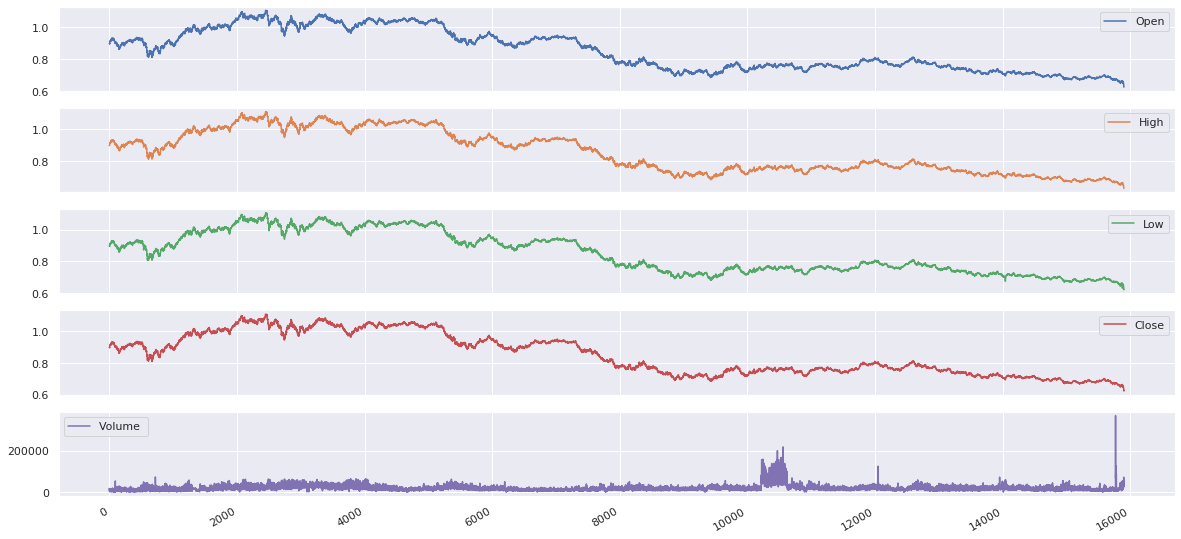

In [ ]:
data.iloc[:,1:].plot(subplots=True, figsize=(20,10))

Text(0, 0.5, 'Stock High price')

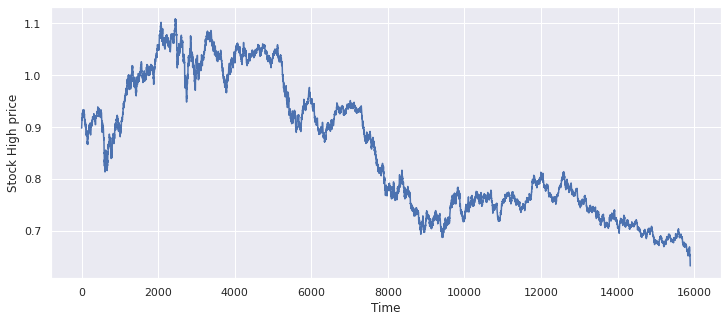

In [ ]:
data['High'].plot(figsize=(12, 5))    # This is the data we want to forecast
plt.xlabel("Time")
plt.ylabel("Stock High price")

## Creating technical indicators

In [ ]:
def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)

def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

def STOK(df, n):
    df['STOK'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

def technical_indicators(data, colname, param):
  """
     This function help us to create some technical indiators of stock market data.
     Technical Indicator : Technical indicators are heuristic or mathematical calculations based on the price,
                           volume, or open interest of a security or contract used by traders who follow 
                           technical analysis.
     Parameter :
    
        colname : which column you want to analyze
        param : containing all the features requires for slicing the data like - moving_average_window, eponential_moving_average_window, roc_window
        return temp_data consists of data's columns with technical_indicators

  """
  temp_data = data.copy()
  
  temp_data['Momentum_1D'] = (temp_data[colname]-temp_data[colname].shift(1)).fillna(0)
  temp_data['RSI_14D'] = temp_data['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
  # temp_data['RSI_14D'] = temp_data['RSI_14D'].fillna(0)

  temp_data['BB_Middle_Band'], temp_data['BB_Upper_Band'], temp_data['BB_Lower_Band'] = bbands(temp_data[colname], length=20, numsd=1)
  # temp_data['BB_Middle_Band'] = temp_data['BB_Middle_Band'].fillna(0)
  # temp_data['BB_Upper_Band'] = temp_data['BB_Upper_Band'].fillna(0)
  # temp_data['BB_Lower_Band'] = temp_data['BB_Lower_Band'].fillna(0)

  temp_data["PVT"] = (temp_data['Momentum_1D']/ temp_data[colname].shift(1))*temp_data['Volume ']
  temp_data["PVT"] = temp_data["PVT"]-temp_data["PVT"].shift(1)
  # temp_data["PVT"] = temp_data["PVT"].fillna(0)

  STOK(temp_data, 4)

  # Moving_average
  moving_average = [np.NaN]*param["moving_average_window"]
  moving_average.extend([sum(temp_data[colname].iloc[i-param["moving_average_window"]:i])/ param["moving_average_window"]
                            for i in range(param["moving_average_window"], temp_data.shape[0])])

  temp_data["Moving_average"] = moving_average          

  #Exponential_moving_average
  temp_data["Exponential_moving_average"] = temp_data[colname].ewm(span=param["eponential_moving_average_window"]).mean().fillna(0)

  # Rate of Change of closing price
  temp_data["ROC"] = ((temp_data[colname]-temp_data[colname].shift(param["roc_window"]))/(temp_data["Close"].shift(param["roc_window"]))) *100

  # Compare a closing price and its price interval
  temp_data["Oversold"] = ((temp_data["Close"] - temp_data["Low"])/ (temp_data["High"] - temp_data["Low"]))


  temp_data["Rolling_mean"] = temp_data[colname].rolling(window =7).mean()   # Rolling mean
  temp_data["Rolling_volatility"] = (temp_data[colname].rolling(window=60).std()) / temp_data[colname]# Rolling volatility
  temp_data["Expanding_mean"] = temp_data[colname].expanding(20).mean()       # Expanding mean

  return temp_data

In [ ]:
def feature_engineering(temp_data, colname, colname1):
  """
    This function help us to create some additional features that might help us to understand the data
    Feature engineering is technique to extract features from raw data.

     Parameter :
    
        colname : which column you want to analyze
        colname1 : some of the features required their opposite attribute to analyze like High or Low 
        return temp_data consists of temp_data's columns with new created features
  """
  feature1 = [np.NaN]  # (high current - high previous)/ (high current - low previous)
  feature2 = [np.NaN]  # (high current - low current)/ (high current - low previous)
  feature3 = [np.NaN]  # (high current - low current)/ ((high previous - low previous)+(high current - low current))
  
  # Creating new features
  temp_data['Time (UTC)'] = pd.to_datetime(temp_data['Time (UTC)'],format='%Y-%m-%d %H:%M')  # datetime format
  temp_data["Day"] = temp_data["Time (UTC)"].dt.day                                          # pick day
  temp_data["Month"] = temp_data["Time (UTC)"].dt.month                                      # pick month
  temp_data["Hour"] =  temp_data["Time (UTC)"].dt.hour                                       # pick hour
  temp_data["Day of Week"] = temp_data["Time (UTC)"].dt.dayofweek                            # pick dayofweek

  temp_data.index = temp_data["Time (UTC)"]

  temp_data['Momentum'] = (temp_data[colname] - temp_data[colname].shift(20)) / temp_data[colname]

  for i in range(1,len(temp_data)):
      feature1.append((temp_data[colname].iloc[i]- temp_data[colname][i-1])/(temp_data[colname].iloc[i]- temp_data[colname1].iloc[i-1]))
      feature2.append((temp_data[colname].iloc[i]- temp_data[colname1][i])/(temp_data[colname].iloc[i]- temp_data[colname1].iloc[i-1]))
      feature3.append((temp_data[colname].iloc[i]- temp_data[colname1][i])/ ((temp_data[colname].iloc[i-1]- temp_data[colname1].iloc[i-1])+ (temp_data[colname].iloc[i]- temp_data[colname1][i])))

  temp_data["Feature1"] = feature1
  temp_data["Feature2"] = feature2
  temp_data["Feature3"] = feature3
  
  # temp_data["Feature4"] = temp_data[colname] - temp_data[colname].shift(1, axis=0) # Change in high price from previous day
  temp_data["Feature5"] = temp_data[colname] - temp_data[colname1].shift(1, axis=0) # Change in the market between high and low price
  temp_data["Feature6"]= (temp_data["High"] - temp_data["High"].shift(3, axis=0))/(temp_data["High"]- temp_data["Low"].shift(3, axis=0))
                  # [High.current – High.3-steps-earlier] / [High.current – Low.3-steps-earlier]

  temp_data["Feature7"] = (temp_data[colname]-temp_data[colname].shift(7, axis=0)) / (temp_data[colname]-temp_data[colname1].shift(7, axis=0))
                  #  [High.current – High.7-steps-earlier] / [High.current – Low.7-steps-earlier]
  temp_data = temp_data.dropna()
  l = list(data.columns)
  l.remove(colname)
  # l.remove(colname1)
  temp_data = temp_data.drop(l, axis =1)

  col = temp_data.columns
  for i in range(temp_data.shape[0]):     #delete
    for j in col:
      if(math.isinf(temp_data[j].iloc[i])):
        temp_data[j].iloc[i] = 0.0

  return temp_data

In [ ]:
param_data = {"moving_average_window" : 22, "eponential_moving_average_window" :22, "roc_window" : 7}

temp_data = technical_indicators(data, "High", param_data)
temp_data = feature_engineering(temp_data, "High", "Low")

index_list = list(data["Time (UTC)"])


In [ ]:
temp_data = temp_data.dropna()
pos = list(index_list).index("2018.12.13 22:00:00")+1

temp_data.head()

,High,Moving_average,Exponential_moving_average,ROC,Oversold,Rolling_mean,Rolling_volatility,Expanding_mean,Day,Month,Hour,Day of Week,Momentum,Feature1,Feature2,Feature3,Feature5,Feature6,Feature7
Time (UTC),,,,,,,,,,,,,,,,,,,
2010-01-14 22:00:00,0.93206,0.928930,0.928506,0.797481,0.348039,0.931581,0.011315,0.920222,14,1,22,3,-0.000172,0.012346,3.777778,0.792746,0.00162,0.282258,0.703244
2010-01-15 02:00:00,0.92916,0.928933,0.928563,-0.073139,0.683473,0.931484,0.010956,0.920369,15,1,2,4,-0.003143,-0.900621,1.108696,0.368421,0.00322,-17.529412,-0.092016
2010-01-15 06:00:00,0.92834,0.928775,0.928544,-0.271827,0.608696,0.931123,0.010514,0.920498,15,1,6,4,-0.002338,-0.298182,1.672727,0.563035,0.00275,1.761905,2.811111
2010-01-15 10:00:00,0.92687,0.928598,0.928398,-0.671300,0.431487,0.930231,0.010011,0.920599,15,1,10,4,-0.002395,-0.469649,1.095847,0.427148,0.00313,-5.580645,3.525424
2010-01-15 14:00:00,0.92731,0.928361,0.928303,-0.398033,0.233743,0.929703,0.009436,0.920704,15,1,14,4,-0.003699,0.113695,1.470284,0.623904,0.00387,-1.075581,3.592233


In [ ]:
print("Total Number of days : {}".format((temp_data.index[-1]-temp_data.index[0]).days))
print("Training number of days : {}".format((temp_data.index[pos]- temp_data.index[0]).days))
print("Testing number of days : {}".format((temp_data.index[-1] - temp_data.index[pos]).days))

Total Number of days : 3709
Training number of days : 3269
Testing number of days : 440


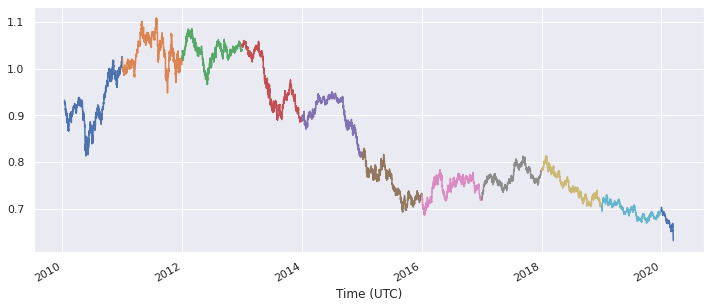

In [ ]:
# this is year wise plot of High only data 

for i in pd.DatetimeIndex(temp_data.index).year.unique(): 
  temp_data["High"][str(i)].plot(figsize =(12, 5))

In [ ]:
num_features = len(list(temp_data.columns))    # number of total features we have created 
temp_data.shape

(15841, 19)

In [ ]:
temp_y = temp_data["High"]                        # label for the prediction
temp_data = temp_data.drop("High", axis=1)       
scaler = MinMaxScaler(feature_range=(0, 1))       # normalising the input data
temp_data = scaler.fit_transform(temp_data)       

scaler1 = MinMaxScaler(feature_range=(0,1))       # normalising the label for prediction
temp_y = scaler1.fit_transform(np.array(temp_y).reshape(-1,1))

temp_data = np.c_[temp_data, temp_y]

In [ ]:
window_size = 22*6
# window_size  will break the data
# let window_size = 3
# then input [a1, a2, a3,...., an]
# will break into [a1, a2, a3] -> a4
#                 [a2, a3, a4] -> a5 and so on...

data_for_model = np.array([temp_data[i:i+window_size] for i in range(temp_data.shape[0]-window_size)])
prediction_for_model = np.array([temp_data[i+window_size, -1] for i in range(temp_data.shape[0]-window_size)])

In [ ]:
# train data : [2010.01.04 06:00:00 to 2018.12.13 22:00:00]
# test data [approx last 15 months]: [2018.12.13 02:00:00 to 2020.03.12 21:00:00]

x_train = data_for_model[:list(index_list).index("2018.12.13 22:00:00")+1]
x_test = data_for_model[list(index_list).index("2018.12.13 22:00:00")+1:]

y_train = prediction_for_model[:list(index_list).index("2018.12.13 22:00:00")+1]
y_test = prediction_for_model[list(index_list).index("2018.12.13 22:00:00")+1:]

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((13968, 132, 19), (1364, 132, 19), (13968,), (1364,))

In [ ]:
# model architecture

# input -> CNN(2 layers) -> LSTM -> dense -> output

param = {'Kernel':3, 'Stride': 1}
model = Sequential()
model.add(Conv1D(64, param['Kernel'], strides = param['Stride'], padding = "same",input_shape = (window_size, num_features)))
model.add(MaxPooling1D())
model.add(Conv1D(64, param['Kernel'], strides = param['Stride'], padding = "same"))
model.add(MaxPooling1D())

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, activation = "linear"))
model.add(Dense(1, activation = "linear"))

model.compile(optimizer = "adam", loss = "mean_squared_error")
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 132, 64)           3712      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 66, 64)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 66, 64)            12352     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 33, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 33, 50)            23000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 33, 50)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1650)            

In [ ]:
model.fit(x_train, y_train, epochs =10, batch_size =16)

Epoch 1/10
13968/13968 [==============================] - 89s 6ms/step - loss: 0.0057
Epoch 2/10
13968/13968 [==============================] - 89s 6ms/step - loss: 8.7822e-04
Epoch 3/10
13968/13968 [==============================] - 88s 6ms/step - loss: 5.6657e-04
Epoch 4/10
13968/13968 [==============================] - 89s 6ms/step - loss: 4.5679e-04
Epoch 5/10
13968/13968 [==============================] - 88s 6ms/step - loss: 3.4663e-04
Epoch 6/10
13968/13968 [==============================] - 89s 6ms/step - loss: 3.0476e-04
Epoch 7/10
13968/13968 [==============================] - 88s 6ms/step - loss: 3.0040e-04
Epoch 8/10
13968/13968 [==============================] - 88s 6ms/step - loss: 2.8997e-04
Epoch 9/10
13968/13968 [==============================] - 89s 6ms/step - loss: 1.9303e-04
Epoch 10/10
13968/13968 [==============================] - 89s 6ms/step - loss: 2.3873e-04


In [ ]:
y_pred = model.predict(x_test) 
y_pred = scaler1.inverse_transform(y_pred)
y_test = scaler1.inverse_transform(y_test.reshape(-1,1))
result = pd.DataFrame()
result["y_true"] = y_test[:,0]
result["y_pred"] = y_pred

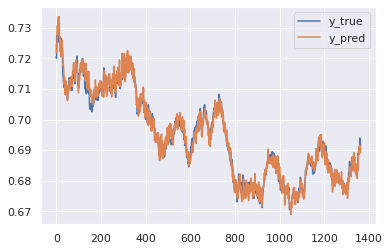

In [ ]:
# plotting the result 
plt.plot(result["y_true"], label="y_true")
plt.plot(result["y_pred"], label="y_pred")
plt.legend()
plt.show()

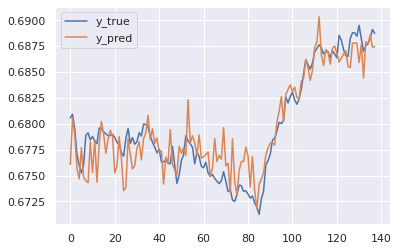

In [ ]:
# Plot of predicitons in random months of 2019
import random
month = random.randint(1,12)
plot_data_y_true = []
plot_data_y_pred = []
year = '2019'
for i in range(pos, len(index_list)):
  if index_list[i].split('.')[0] == year:
    if int(index_list[i].split('.')[1]) == month:
      plot_data_y_true.append(result["y_true"].iloc[i-pos])
      plot_data_y_pred.append(result["y_pred"].iloc[i-pos])

temp = pd.DataFrame()
temp["y_pred"] = plot_data_y_pred
temp["y_true"] = plot_data_y_true

# plotting the random month prediction
plt.plot(temp["y_true"], label="y_true")
plt.plot(temp["y_pred"], label="y_pred")
plt.legend()
plt.show()

In [ ]:
def directional_accuracy(y_pred , y_actual):
  """
    To calculate directional accuracy for model
    parameter:
      Y_pred : forcasted values by model 
      Y_true : actual values
      return : percentage (how many times we correctly predict the movement)
  """
  count =0 
  for i in range(1,len(y_actual)):
    if np.sign(y_actual[i] - y_actual[i-1]) == np.sign(y_pred[i] - y_actual[i-1]):
      count +=1
  return count/len(y_actual)*100

def absolute_error(y_pred, y_actual):
  """
    To calculate absolute error for model (-)ve and (+)ve
    parameter:
      Y_pred : forcasted values by model 
      Y_true : actual values
      return : percentage (how much is the error in our prediction)
  """
  negative_error = []
  positive_error = []
  for i in range(1, len(y_actual)):
    temp = (y_pred[i]-y_actual[i])/abs((y_actual[i-1]-y_actual[i]))
    if temp > 0:
      positive_error.append(temp)
    else:
      negative_error.append(temp)
  return np.average(negative_error), np.average(positive_error)

In [ ]:
print("Directional accuracy for the model is : {} ".format(directional_accuracy(y_pred, y_test)))
temp = absolute_error(y_pred, y_test)
print("Absolute error for the model is : \n Negative error :{} \n Positive error :{} ".format(temp[0], temp[1]))

Directional accuracy for the model is : 58.13782991202346 
Absolute error for the model is : 
 Negative error :-6.397223047454463 
 Positive error :10.284962692351389 


## Validating results 

In [ ]:
# Now trying to predict Low price using this same model 

def validating(data, colname, colname1, param, window_size = 50):
  """
    This function follow some steps:
     - create technical indicators
     - feature engineering steps
     - data preparation (normalization, test train split)
     - prediction
     
     paramters : 
            colname : which column you want to analyze
            colname1 : some of the features required their opposite attribute to analyze like High or Low 
            return : result consists of y_true and y_predicted
  """
  temp_data = technical_indicators(data, colname, param)

  temp_data = feature_engineering(temp_data, colname, colname1)

  num_features = len(list(temp_data.columns))


  temp_y = temp_data[colname]
  temp_data = temp_data.drop(colname, axis=1)
  scaler = MinMaxScaler(feature_range=(0, 1))
  temp_data = scaler.fit_transform(temp_data)

  scaler1 = MinMaxScaler(feature_range=(0,1))
  temp_y = scaler1.fit_transform(np.array(temp_y).reshape(-1,1))

  temp_data = np.c_[temp_data, temp_y]

  data_for_model = np.array([temp_data[i:i+window_size] for i in range(temp_data.shape[0]-window_size)])
  prediction_for_model = np.array([temp_data[i+window_size, -1] for i in range(temp_data.shape[0]-window_size)])

  y_pred = model.predict(data_for_model) 
  y_pred = scaler1.inverse_transform(y_pred)
  y_test = scaler1.inverse_transform(prediction_for_model.reshape(-1,1))
  result = pd.DataFrame()
  result["y_true"] = y_test[:,0]
  result["y_pred"] = y_pred

  return result

In [ ]:
result_low = validating(data, "Low", "High", param_data, window_size=window_size)
result_close = validating(data, "Close", "Open", param_data, window_size =window_size)

Directional accuracy for the model is : 51.00260996880769 
Absolute error for the model is : 
 Negative error :-37.407079683148275 
 Positive error :9.668082266985342 


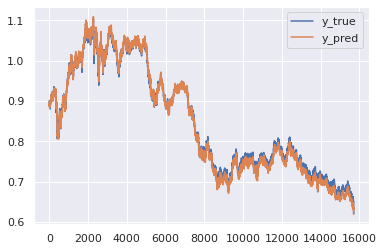

In [ ]:
print("Directional accuracy for the model is : {} ".format(directional_accuracy(result_low["y_pred"], result_low["y_true"])))
temp = absolute_error(result_low["y_pred"], result_low["y_true"])
print("Absolute error for the model is : \n Negative error :{} \n Positive error :{} ".format(temp[0], temp[1]))

# plotting the result 
plt.plot(result_low["y_true"], label="y_true")
plt.plot(result_low["y_pred"], label="y_pred")
plt.legend()
plt.show()

Directional accuracy for the model is : 49.38570246355592 
Absolute error for the model is : 
 Negative error :-33.92583456221717 
 Positive error :0.8285766630109761 


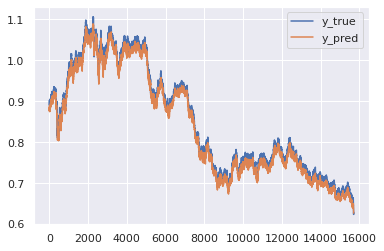

In [ ]:
print("Directional accuracy for the model is : {} ".format(directional_accuracy(result_close["y_pred"], result_close["y_true"])))
temp = absolute_error(result_close["y_pred"], result_close["y_true"])
print("Absolute error for the model is : \n Negative error :{} \n Positive error :{} ".format(temp[0], temp[1]))

# plotting the result 
plt.plot(result_close["y_true"], label="y_true")
plt.plot(result_close["y_pred"], label="y_pred")
plt.legend()
plt.show()